### 9.1.1 Working with CSKs

In [1]:
kB <- function(r, rmax) 
 {
  rnorm <- r/rmax
  k <- (1 - rnorm)*cos(pi*rnorm) + sin(pi*rnorm)/pi
  k <- k*(r < rmax)
 }

In [2]:
library(plgp)

Loading required package: mvtnorm

Loading required package: tgp



In [3]:
X <- matrix(seq(0, 10, length=2000), ncol=1)
D <- distance(X)

In [4]:
eps <- sqrt(.Machine$double.eps)  ## numerical stability
K <- exp(-D) + diag(eps, nrow(D))
K2 <- kB(sqrt(D), 2)
K1 <- kB(sqrt(D), 1)
K025 <- kB(sqrt(D), 0.25)
c(mean(K > 0), mean(K2 > 0), mean(K1 > 0), mean(K025 > 0))

[1] 1.0000000 0.3596000 0.1895500 0.0488875

In [5]:
library(Matrix)
c(system.time(chol(K))[3], 
  system.time(chol(Matrix(K2, sparse=TRUE)))[3],
  system.time(chol(Matrix(K1, sparse=TRUE)))[3], 
  system.time(chol(Matrix(K025, sparse=TRUE)))[3])

elapsed elapsed elapsed elapsed 
  0.037   0.257   0.106   0.075

In [6]:
set.seed(31231)
x <- c(1, 2, 4, 5, 6, 8, 9, 10)/11
n <- length(x)
D <- distance(as.matrix(x))
K <- exp(-5*sqrt(D)^1.5) + diag(eps, n)
library(mvtnorm)
y <- t(rmvnorm(1, sigma=K))

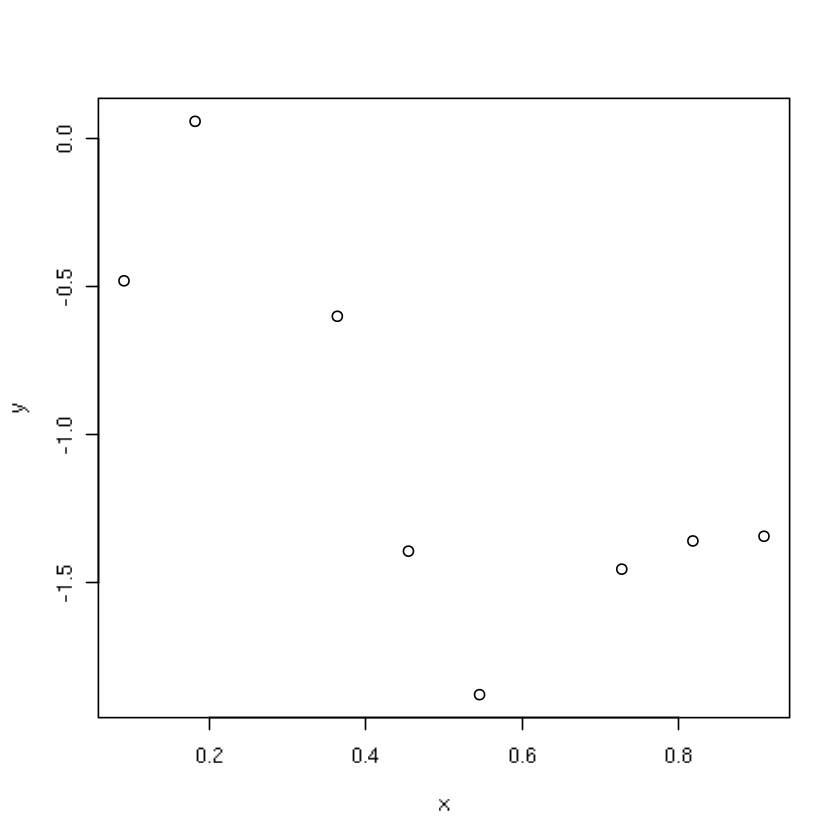

In [7]:
plot(x, y)

In [8]:
xx <- seq(0, 1, length=100)
DX <- distance(as.matrix(x), as.matrix(xx))
KX <- exp(-5*sqrt(DX)^1.5)
Ki <- solve(K)
m <- t(KX) %*% Ki %*% y
Sigma <- diag(1+eps, ncol(KX)) - t(KX) %*% Ki %*% KX
q1 <- qnorm(0.05, m, sqrt(diag(Sigma)))
q2 <- qnorm(0.95, m, sqrt(diag(Sigma)))

In [9]:
K01 <- kB(sqrt(D), 0.1)
KX01 <- kB(sqrt(DX), 0.1)
Ki01 <- solve(K01)
m01 <- t(KX01) %*% Ki01 %*% y
tau2 <- drop(t(y) %*% Ki01 %*% y)/n
Sigma01 <- tau2*(1 - t(KX01) %*% Ki01 %*% KX01)
q101 <- qnorm(0.05, m01, sqrt(diag(Sigma01)))
q201 <- qnorm(0.95, m01, sqrt(diag(Sigma01)))

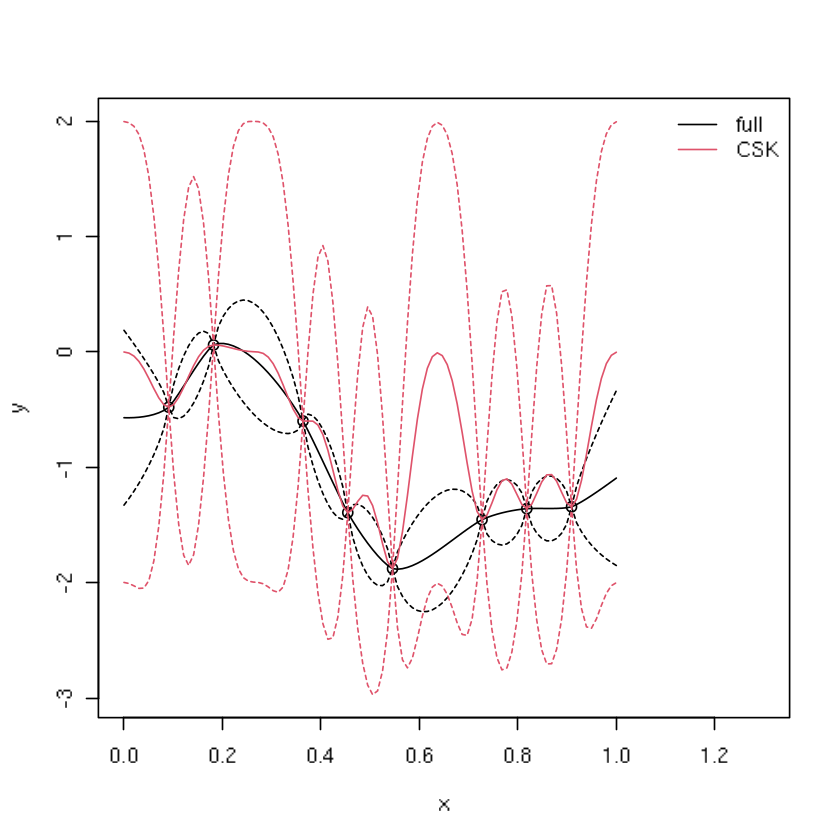

In [10]:
plot(x, y, xlim=c(0, 1.3), ylim=range(q101, q201))
lines(xx, m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
lines(xx, m01, col=2)
lines(xx, q101, col=2, lty=2)
lines(xx, q201, col=2, lty=2)
legend("topright", c("full", "CSK"), lty=1, col=1:2, bty="n")

### 9.1.2 Sharing load between mean and variance

In [11]:
install.packages("/root/SparseEm_0.2-2.tar.gz", repos=NULL, type="source")

In [12]:
library(SparseEm)

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve




In [13]:
leg01 <- legFun(0, 1)
degree <- 4
X <- leg01(x, terms=polySet(1, degree, 2, degree)) 
colnames(X) <- paste0("l", 0:(ncol(X) - 1))
X <- data.frame(X)
X

l0,l1,l2,l3,l4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4171325,1.1272739,-0.3756927,-0.5243494
1,-1.1022142,0.2402387,0.8209581,-1.2783963
1,-0.4723775,-0.8685553,0.9481768,0.3608360
1,-0.1574592,-1.0903141,0.3558148,1.0329212
1,0.1574592,-1.0903141,-0.3558148,1.0329212
1,0.7872958,-0.4250377,-1.1827363,-0.6390957
1,1.1022142,0.2402387,-0.8209581,-1.2783963
1,1.4171325,1.1272739,0.3756927,-0.5243494


In [14]:
lfit <- lm(y ~ . -1, data=X)
lfit


Call:
lm(formula = y ~ . - 1, data = X)

Coefficients:
     l0       l1       l2       l3       l4  
-1.1334  -0.3896  -0.0291   0.3601  -0.4448  


In [15]:
XX <- leg01(xx, terms=polySet(1, degree, 2, degree)) 
colnames(XX) <- paste0("l", 0:(ncol(X) - 1))
p <- predict(lfit, newdata=data.frame(XX), interval="prediction", level=0.9)

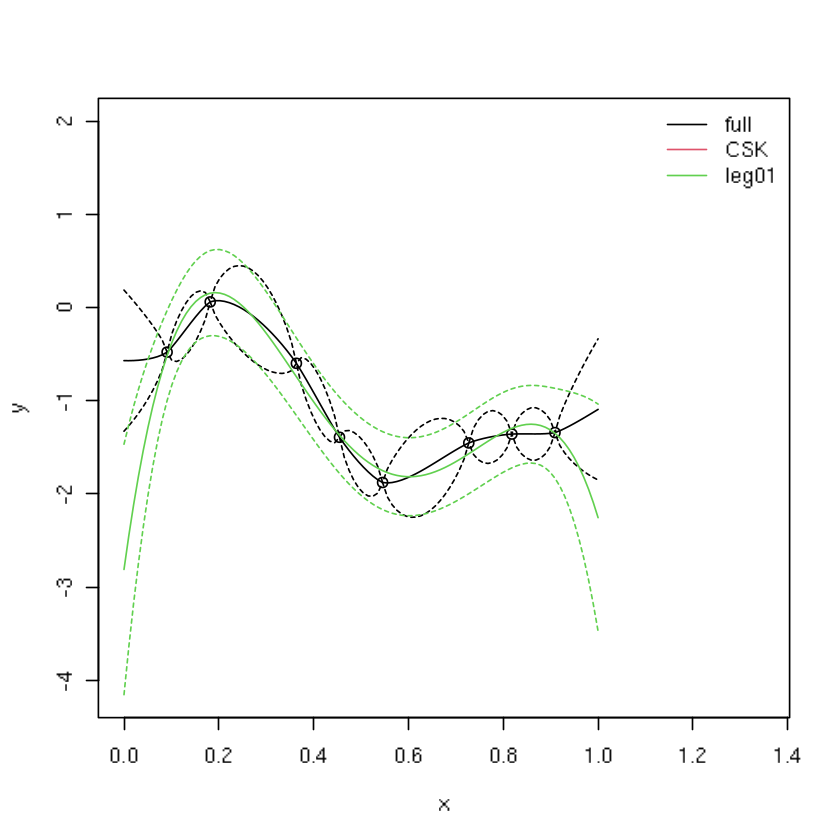

In [16]:
plot(x, y, xlim=c(0, 1.35), ylim=range(q101, q201, p[,2], p[,3]))
lines(xx, m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
# lines(xx, m01, col=2)
# lines(xx, q101, col=2, lty=2)
# lines(xx, q201, col=2, lty=2)
lines(xx, p[,1], col=3)
lines(xx, p[,2], col=3, lty=2)
lines(xx, p[,3], col=3, lty=2)
legend("topright", c("full", "CSK", "leg01"), lty=1, col=1:3, bty="n")

In [17]:
m2 <- t(KX01) %*% Ki01 %*% lfit$resid
tau22 <- drop(t(lfit$resid) %*% Ki01 %*% lfit$resid)/n
Sigma2 <- tau22*(1 - t(KX01) %*% Ki01 %*% KX01)

In [18]:
m2 <- p[,1] + m2
q12 <- qnorm(0.05, m2, sqrt(diag(Sigma2)))
q22 <- qnorm(0.95, m2, sqrt(diag(Sigma2)))

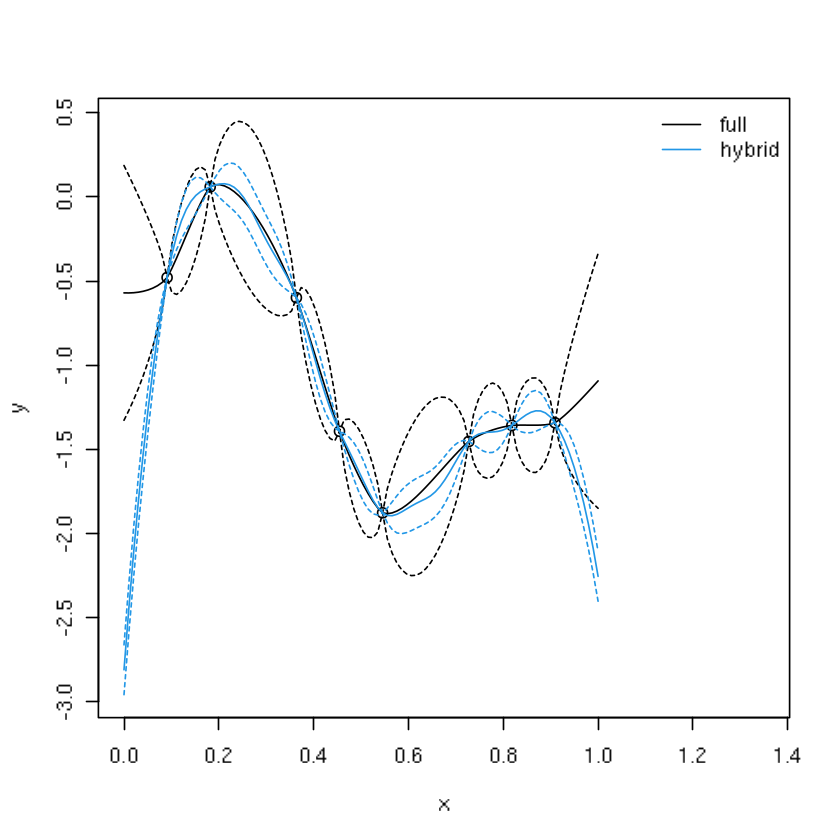

In [19]:
plot(x, y, xlim=c(0, 1.35), ylim=range(q1, q2, q12, q22))
lines(xx,m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
lines(xx, m2, col=4)
lines(xx, q12, col=4,lty=2)
lines(xx, q22, col=4,lty=2)
legend("topright", c("full", "hybrid"), lty=1, col=c(1,4), bty="n")

In [20]:
c(ideal=tau2, CSKresid=tau22)


ideal    CSKresid 
1.472997631 0.008098985

### 9.1.3 Practical Bayesian inference and UQ

In [21]:
borehole <- function(x)
 {
  rw <- x[1]*(0.15 - 0.05) + 0.05
  r <-  x[2]*(50000 - 100) + 100
  Tu <- x[3]*(115600 - 63070) + 63070
  Hu <- x[4]*(1110 - 990) + 990
  Tl <- x[5]*(116 - 63.1) + 63.1
  Hl <- x[6]*(820 - 700) + 700
  L <-  x[7]*(1680 - 1120) + 1120
  Kw <- x[8]*(12045 - 9855) + 9855
  m1 <- 2*pi*Tu*(Hu - Hl)
  m2 <- log(r/rw)
  m3 <- 1 + 2*L*Tu/(m2*rw^2*Kw) + Tu/Tl
  return(m1/m2/m3)
 }

In [22]:
# n <- 4000
# nn <- 500
# m <- 8
# library(lhs)
# x <- randomLHS(n + nn, m)
# y <- apply(x, 1, borehole)
# X <- x[1:n,]
# Y <- y[1:n]
# XX <- x[-(1:n),]
# YY <- y[-(1:n)]

In [23]:
# C <- find.tau(den=1 - 0.99, dim=ncol(x))*ncol(X) 
# C

[1] 2.707658

In [24]:
# D <- I <- 2
# B <- 2000
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps99 <- mcmc.sparse(Y, X, mc=C, degree=D, maxint=I, 
#     B=B, verbose=FALSE) 
# })
# time99 <- as.numeric(proc.time()[3] - tic)

In [25]:
# par(mfrow=c(1,2))
# matplot(samps99, type="l", xlab="iter")
# plot(rowSums(samps99), type="l", xlab="iter", ylab="Rc")

In [26]:
# library(coda)
# burnin <- 500
# apply(samps99[-(1:burnin),], 2, effectiveSize)

In [27]:
# time99/60

In [28]:
# index <- seq(burnin+1, B, by=10)
# tic <- proc.time()[3]
# suppressWarnings({ 
#   p99 <- pred.sparse(samps99[index,], X, Y, XX, degree=D, 
#     maxint=I, verbose=FALSE) 
# })
# time99 <- as.numeric(time99 + proc.time()[3] - tic)
# time99/60

In [29]:
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps0 <- mcmc.nonsparse(Y, X, B=B/3, verbose=FALSE) 
# })
# index <- seq(burnin/3 + 1, B/3, by=10)
# suppressWarnings({ 
#   p0 <- pred.nonsparse(samps0[index,], X, Y, XX, 2, verbose=FALSE) 
# })
# time0 <- as.numeric(proc.time()[3] - tic)

In [30]:
# matplot(samps0, type="l", xlab="iter")

In [31]:
# time0/60

In [32]:
# scorep <- function(YY, mu, s2) { mean(-(mu - YY)^2/s2 - log(s2)) }
# scores <- c(sparse99=scorep(YY, p99$mean, p99$var), 
#   dense=scorep(YY, p0$mean, p0$var))
# scores

In [33]:
# C <- find.tau(den=1 - 0.999, dim=ncol(x))*ncol(x) 
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps999 <- mcmc.sparse(Y, X, mc=C, degree=D, maxint=I, 
#     B=B, verbose=FALSE) 
# })
# index <- seq(burnin+1, B, by=10)
# suppressWarnings({ 
#   p999 <- pred.sparse(samps999[index,], X, Y, XX, degree=D, 
#     maxint=I, verbose=FALSE) 
# })
# time999 <- as.numeric(proc.time()[3] - tic)

In [34]:
# times <- c(sparse99=time99, dense=time0, sparse999=time999)
# times

In [35]:
# scores <- c(scores, sparse999=scorep(YY, p999$mean, p999$var))
# scores

### 9.2.1 Divie-and-conquer regression

In [36]:
library(MASS)
library(tgp)

In [38]:
XX <- seq(0, max(mcycle[,1]), length=1000)
out.bcart <- bcart(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=100, verb=0)

In [40]:
outp.bcart <- predict(out.bcart, XX=XX)

In [58]:
plot.moto <- function(out, outp)
 {
  plot(outp$XX[,1], outp$ZZ.km, ylab="accel", xlab="time", 
   ylim=c(-150, 80), lty=2, col=1, type="l")
  points(mcycle)
#   lines(outp$XX[,1], outp$ZZ.km + 1.96*sqrt(outp$ZZ.ks2), col=2, lty=2)
#   lines(outp$XX[,1], outp$ZZ.km - 1.96*sqrt(outp$ZZ.ks2), col=2, lty=2)
  lines(out$XX[,1], out$ZZ.mean, col=1, lwd=2)
  lines(out$XX[,1], out$ZZ.q1, col=2, lwd=2)
  lines(out$XX[,1], out$ZZ.q2, col=2, lwd=2)
 }

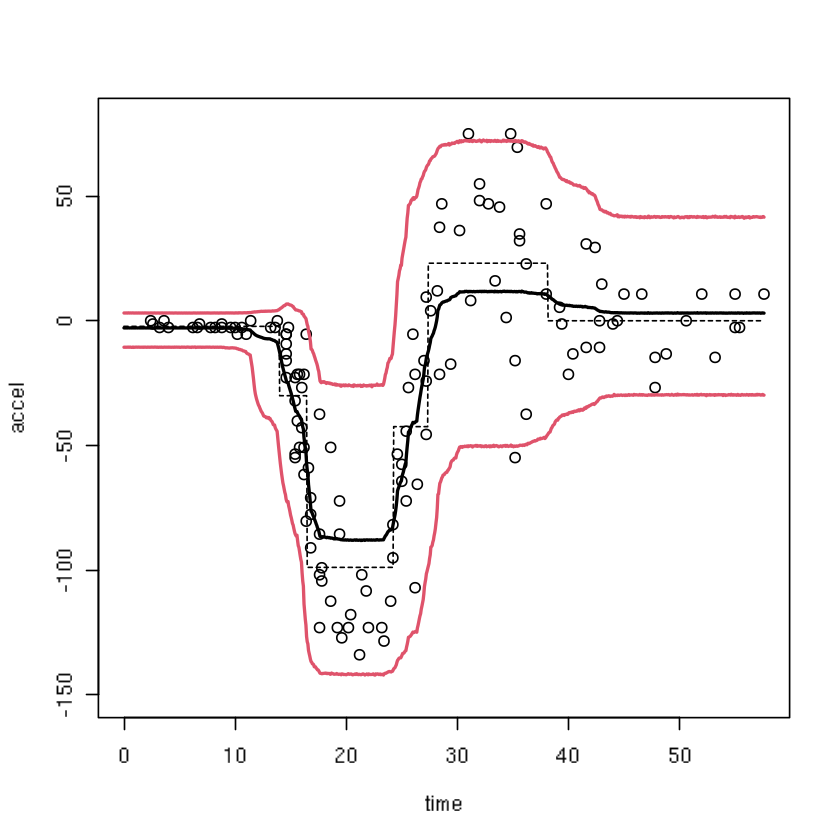

In [59]:
plot.moto(out.bcart, outp.bcart)

In [60]:
out.btlm <- btlm(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=100, verb=0)
outp.btlm <- predict(out.btlm, XX=XX)

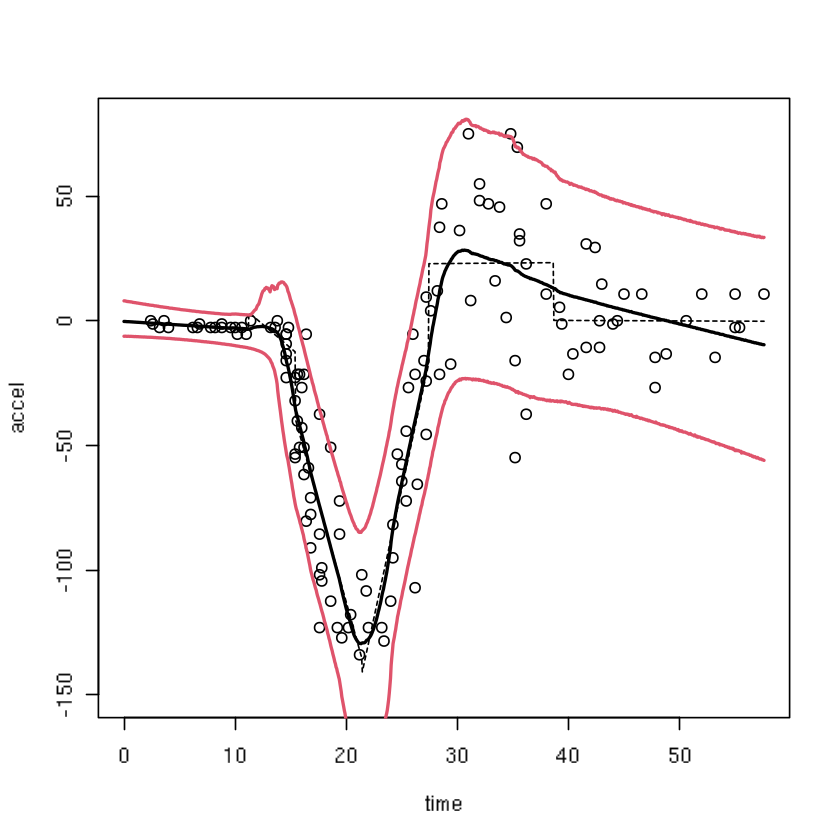

In [62]:
plot.moto(out.btlm, outp.btlm)

In [63]:
out.bgp <- bgp(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=10, verb=0)
outp.bgp <- predict(out.bgp, XX=XX)

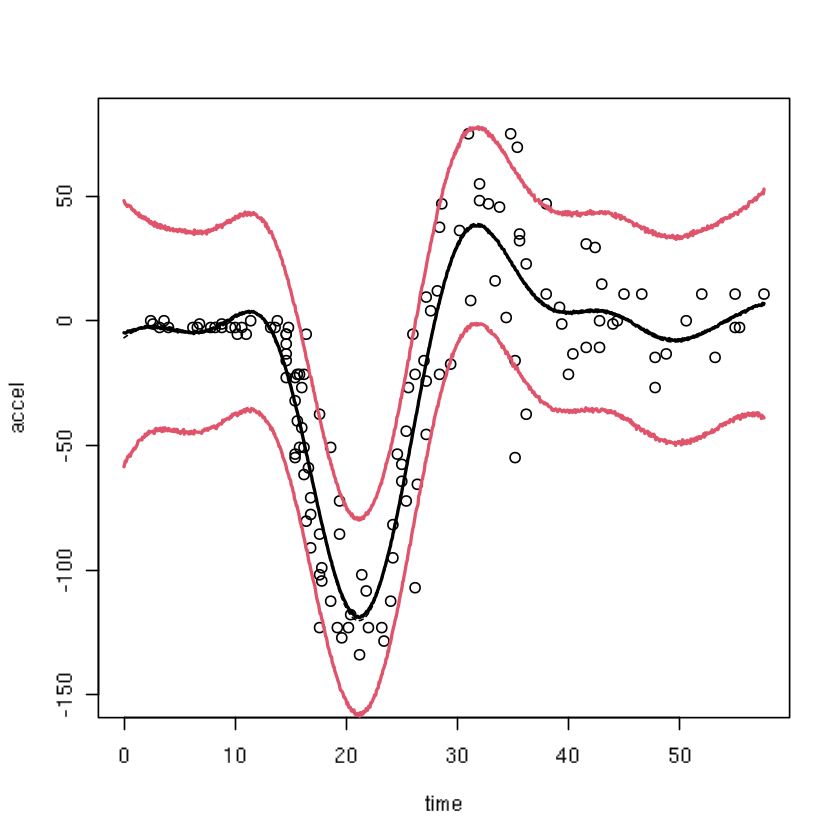

In [64]:
plot.moto(out.bgp, outp.bgp)

### 9.2.2 Treed Gaussian process

In [65]:
tic <- proc.time()[3]
out.btgp <- btgp(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=30, 
  bprior="b0", verb=0)
toc <- proc.time()[3]
toc - tic

elapsed 
529.977

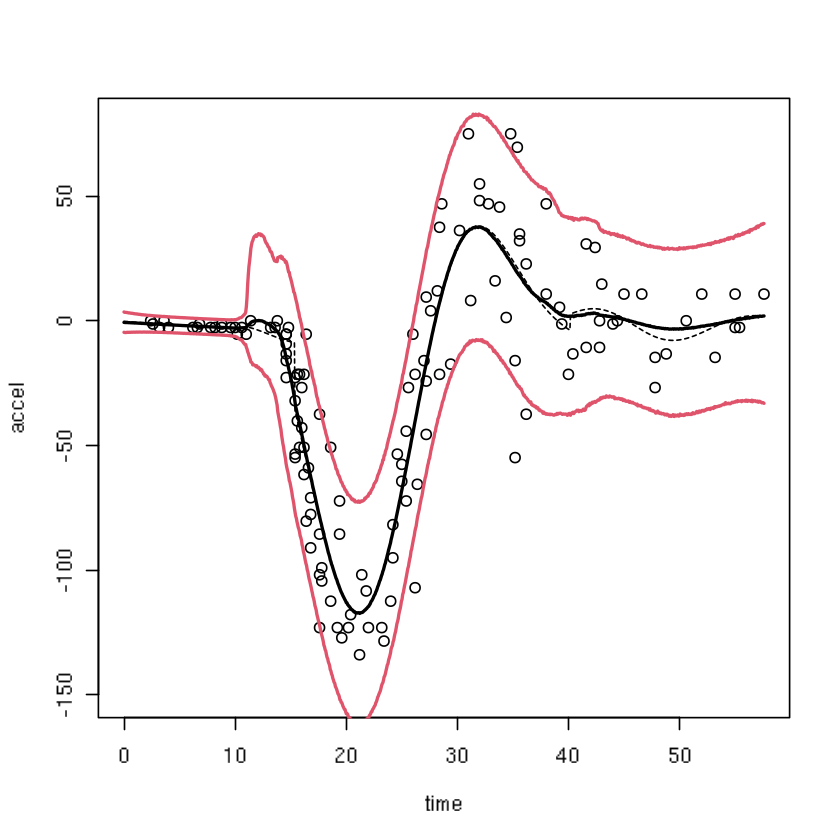

In [67]:
outp.btgp <- predict(out.btgp, XX=XX)
plot.moto(out.btgp, outp.btgp)

In [68]:
tic <- proc.time()[3]
out.btgpllm <- btgpllm(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=30, 
  bprior="b0", verb=0)
outp.btgpllm <- predict(out.btgpllm, XX=XX)
toc <- proc.time()[3]
toc - tic

elapsed 
470.682

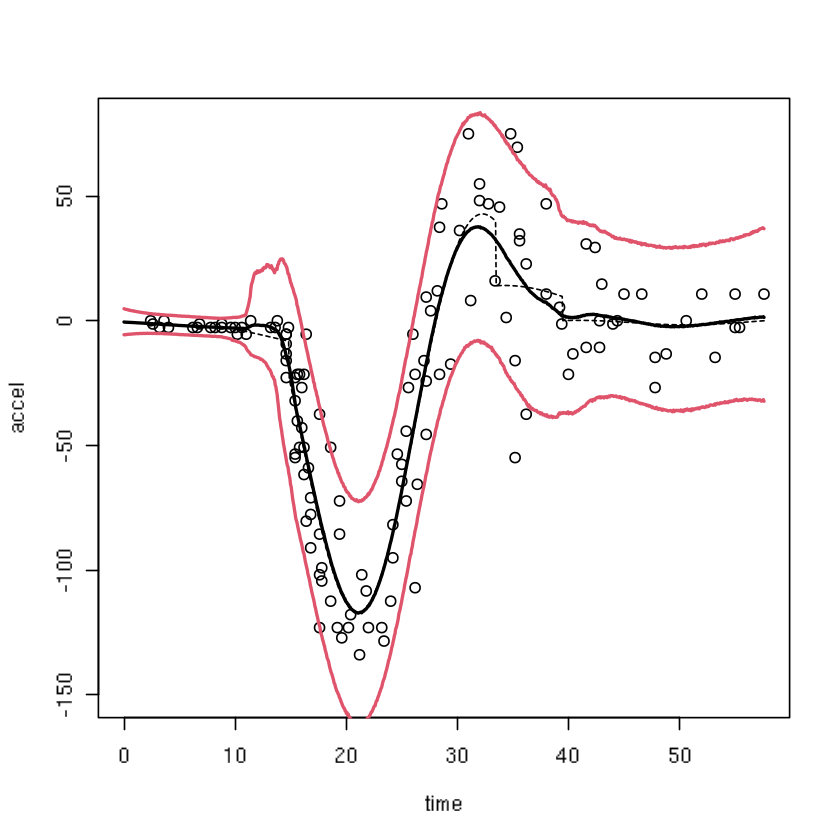

In [69]:
outp.btgpllm <- predict(out.btgpllm, XX=XX)
plot.moto(out.btgpllm, outp.btgpllm)

In [70]:
exp2d.data <- exp2d.rand(n1=30, n2=70)
X <- exp2d.data$X
Z <- exp2d.data$Z
XX <- exp2d.data$XX

In [71]:
out.bgp <- bgp(X=X, Z=Z, XX=XX, corr="exp", verb=0)

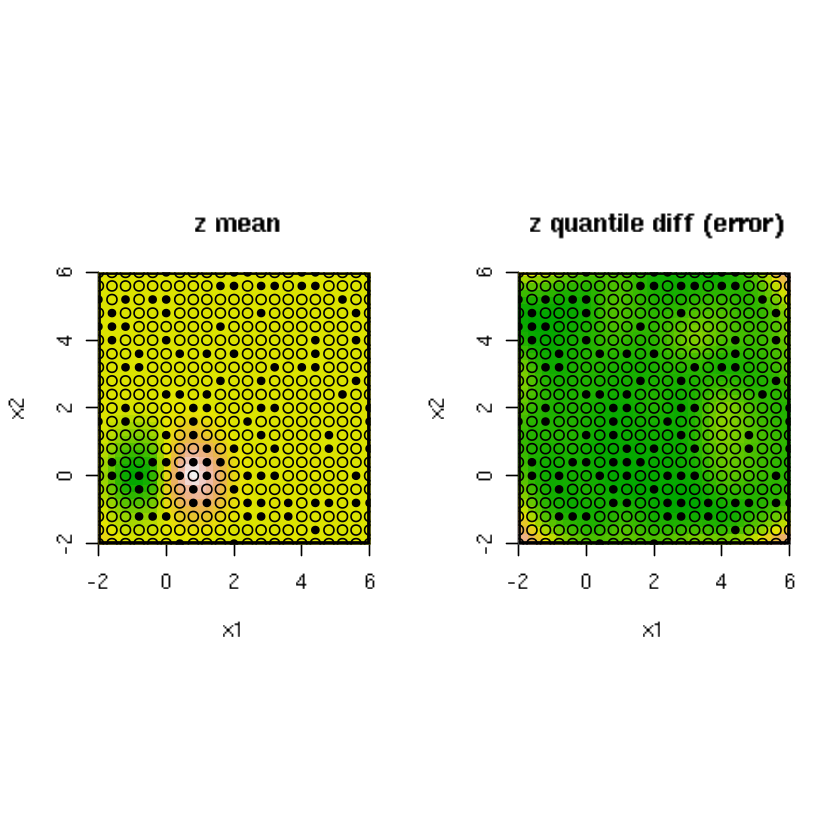

In [76]:
par(pty="s")
plot(out.bgp, pc="c")

In [73]:
out.btgp <- btgp(X=X, Z=Z, XX=XX, corr="exp", R=10, verb=0)

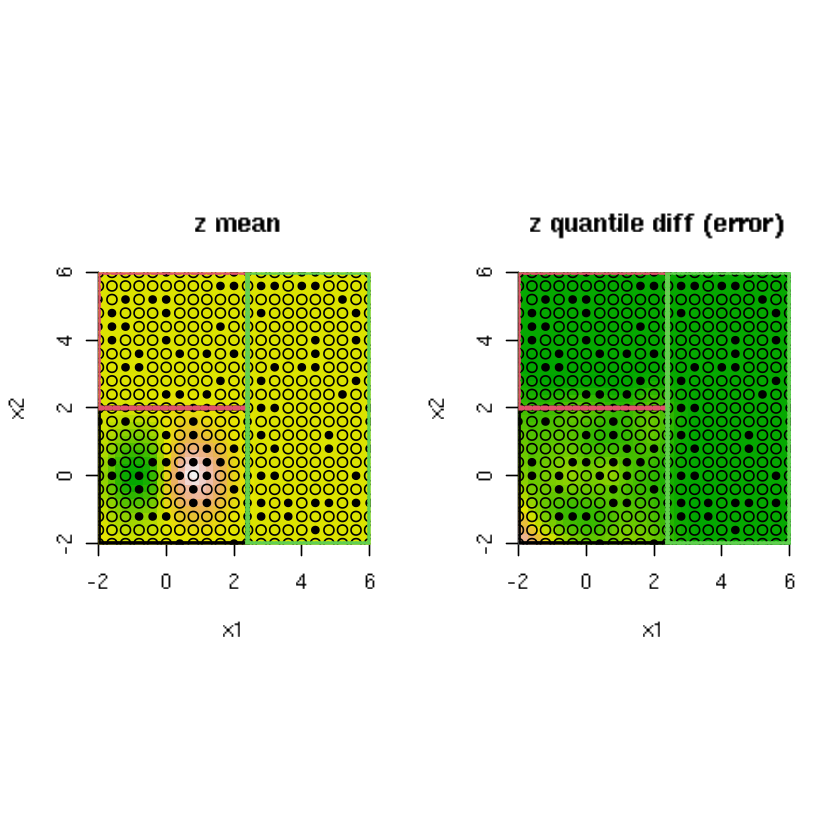

In [77]:
par(pty="s")
plot(out.btgp, pc="c")

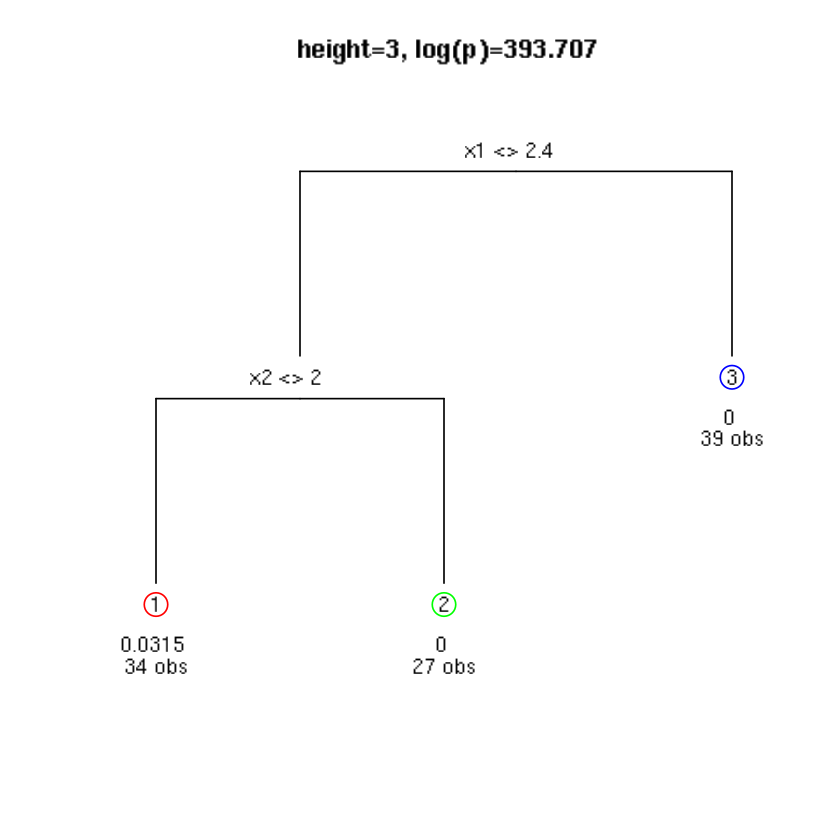

In [75]:
tgp.trees(out.btgp, heights="map")


In [90]:
setwd("/root")
lgbb.as <- read.table("./dataset/lgbb/lgbb_as.txt", header=TRUE)
lgbb.rest <- read.table("./dataset/lgbb/lgbb_as_rest.txt", header=TRUE)

In [91]:
X <- lgbb.as[,2:4]
Y <- lgbb.as$lift
XX <- lgbb.rest[,2:4]
c(X=nrow(X), XX=nrow(XX))

X    XX 
  780 37128

In [92]:
t1 <- system.time(fit <- btgpllm(X=X, Z=Y, XX=XX, bprior="b0", verb=0))[3]
t1/60

elapsed 
38.81085

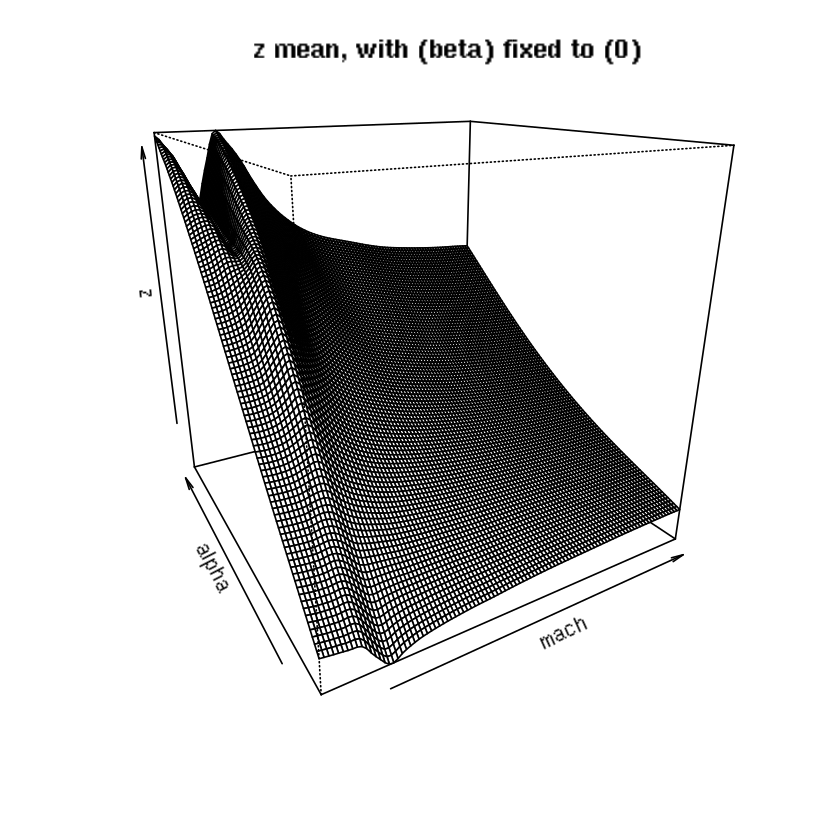

In [99]:
plot(fit, slice=list(x=3, z=0), gridlen=c(100, 100), 
  layout="surf", span=0.01)

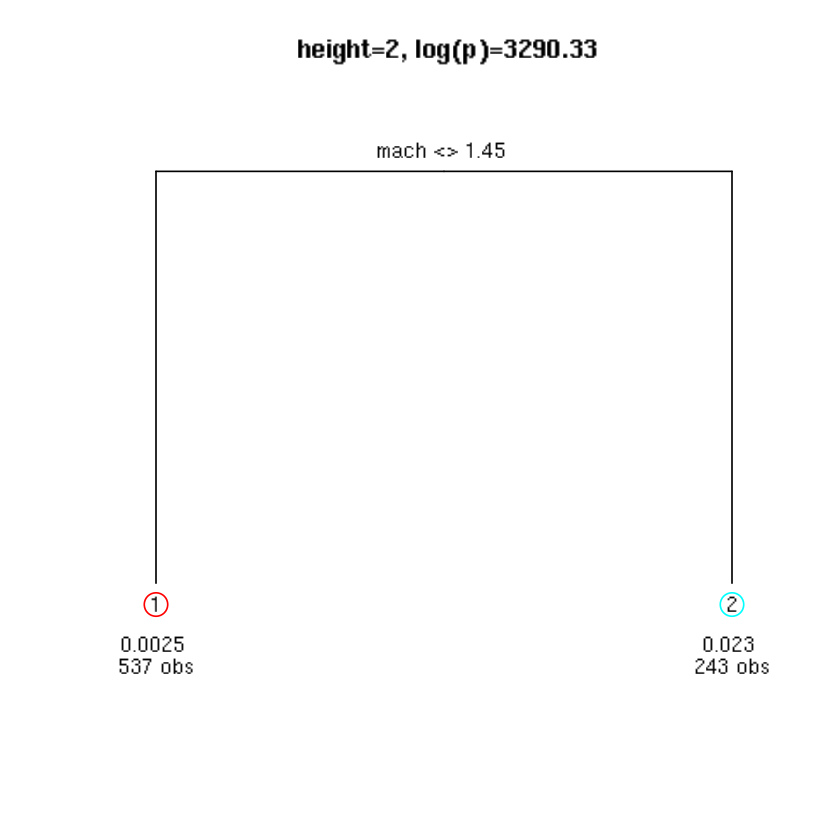

In [100]:
tgp.trees(fit, heights="map")

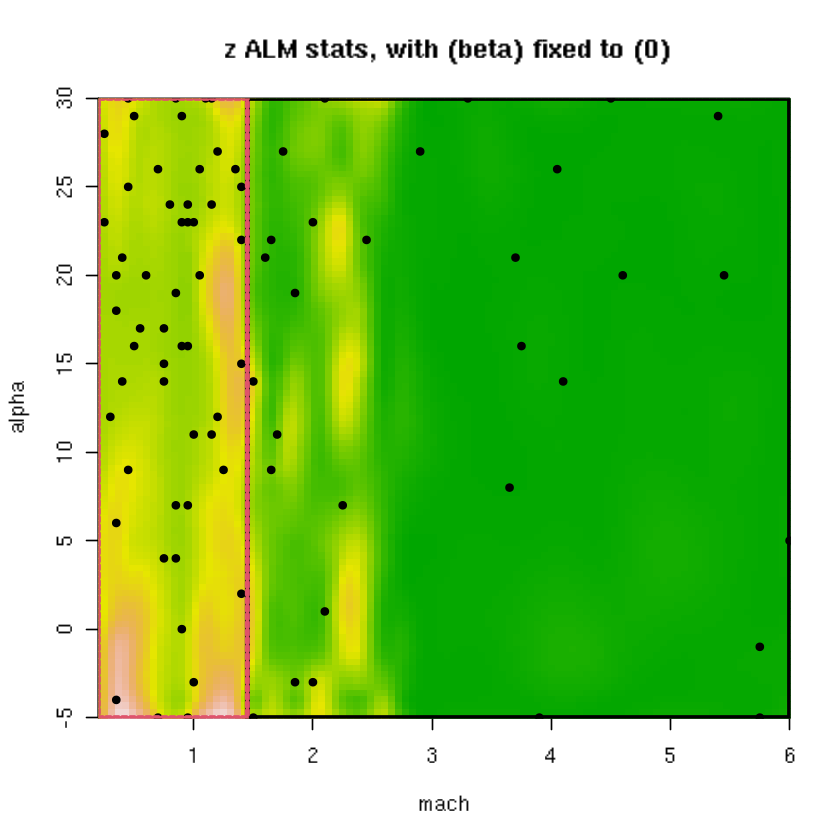

In [101]:
plot(fit, slice=list(x=3,z=0), gridlen=c(100,100), layout="as", as="alm", 
  span=0.01, pXX=FALSE)

In [102]:
t2 <- system.time(
  fit2 <- btgpllm(X=X, Z=Y, XX=XX, bprior="b0", linburn=TRUE, verb=0))[3]

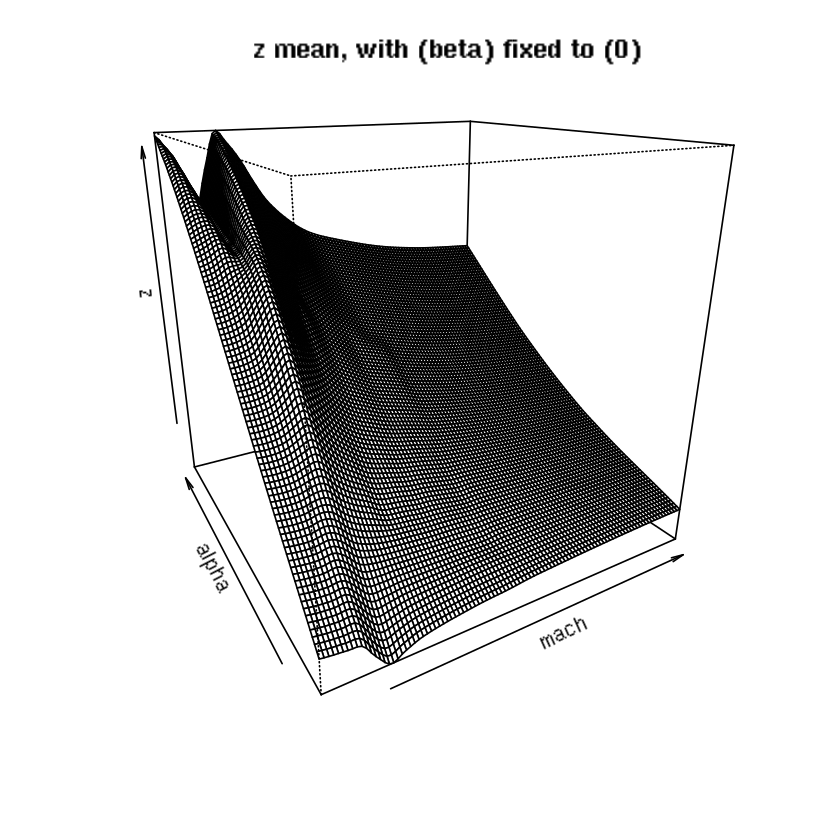

In [103]:
plot(fit2, slice=list(x=3, z=0), gridlen=c(100, 100), 
  layout="surf", span=0.01)

In [104]:
c(full=t1, linburn=t2)

full.elapsed linburn.elapsed 
       2328.651         430.107

In [105]:
map.height <-fit2$post$height[which.max(fit2$posts$lpost)]
leafs.n <- fit2$trees[[map.height]]$n
1 - sum(leafs.n^2)/(sum(leafs.n)^2)

[1] 0.8990594

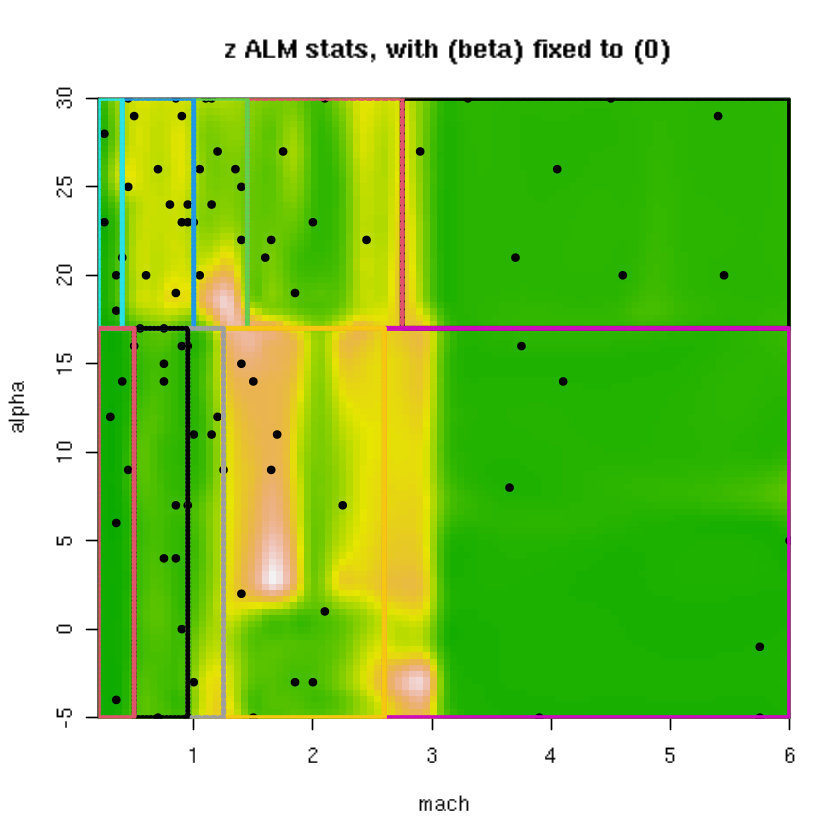

In [106]:
plot(fit2, slice=list(x=3,z=0), gridlen=c(100,100), layout="as", as="alm", 
  span=0.01, pXX=FALSE)

In [107]:
t3 <- system.time(
  fit3 <- btlm(X=X, Z=Y, XX=XX, BTE=c(2000, 7000, 10), R=10, verb=0))[3]

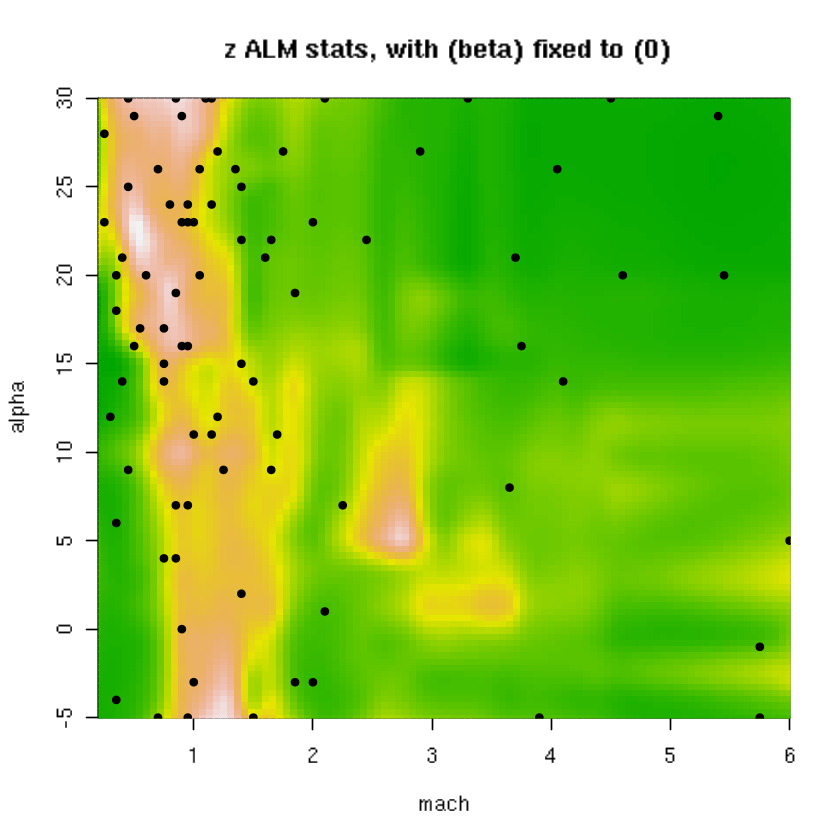

In [108]:
plot(fit3, slice=list(x=3,z=0), gridlen=c(100,100), layout="as", as="alm", 
  span=0.01, pparts=FALSE, pXX=FALSE)

In [109]:
c(full=t1, linburn=t2, btlm=t3)

full.elapsed linburn.elapsed    btlm.elapsed 
       2328.651         430.107         489.692

### 9.2.3 Regression tree extensions, off-shoots and fix-ups

In [111]:
install.packages("dynaTree")
library(dynaTree)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dynaTree’


The following object is masked from ‘package:tgp’:

    sens




In [112]:
XX <- seq(0,max(mcycle[,1]), length=1000)
out.dtc <- dynaTrees(X=mcycle[,1], y=mcycle[,2], XX=XX, verb=0, pverb=0)
out.dtl <- dynaTrees(X=mcycle[,1], y=mcycle[,2], XX=XX, model="linear", 
  verb=0, pverb=0)

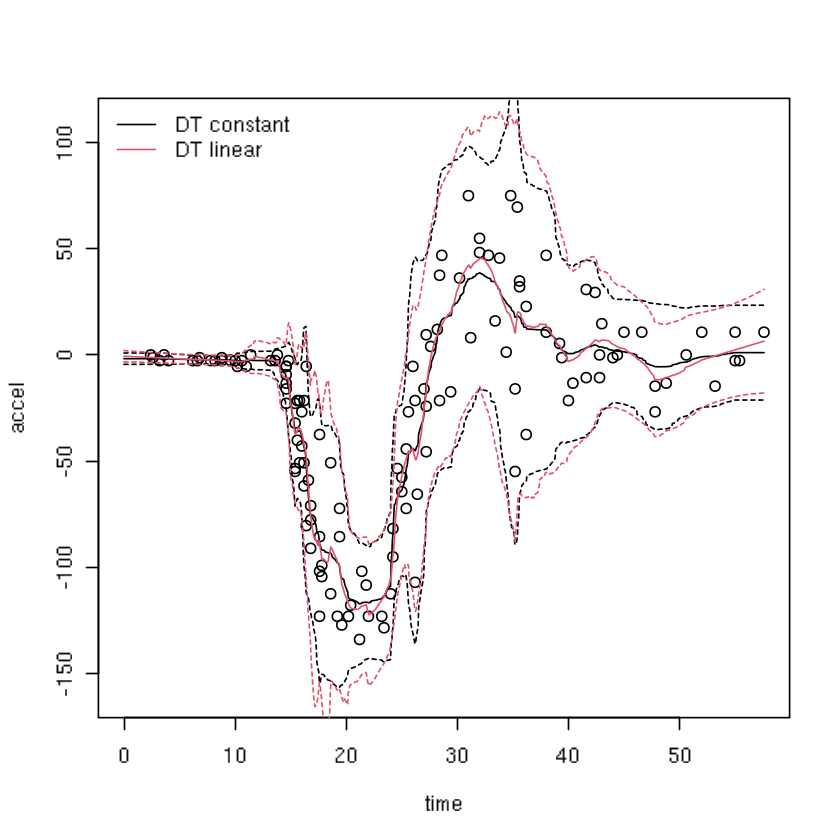

In [113]:
plot(out.dtc$XX[,1], rowMeans(out.dtc$mean), type="l", ylim=c(-160, 110), 
  ylab="accel", xlab="time")
points(mcycle)
lines(out.dtc$XX[,1], rowMeans(out.dtc$q1), lty=2)
lines(out.dtc$XX[,1], rowMeans(out.dtc$q2), col=1, lty=2)
lines(out.dtl$XX[,1], rowMeans(out.dtl$mean), col=2)
lines(out.dtl$XX[,1], rowMeans(out.dtl$q1), col=2, lty=2)
lines(out.dtl$XX[,1], rowMeans(out.dtl$q2), col=2, lty=2)
legend("topleft", legend=c("DT constant", "DT linear"), bty="n", 
  lty=1, col=1:2)

## 9.3 Local approximate GPs

### 9.3.2 Illustrating LAGP: ALC v. MSPE

In [20]:
xg <- seq(-2, 2, by=0.02)
X <- as.matrix(expand.grid(xg, xg))
nrow(X)

[1] 40401

In [21]:
herbtooth <- function(X)
 {
  g <- function(z)
    return(exp(-(z - 1)^2) + exp(-0.8*(z + 1)^2) - 0.05*sin(8*(z + 0.1))) 
  return(-apply(apply(X, 2, g), 1, prod))
 }

In [22]:
Y <- herbtooth(X)

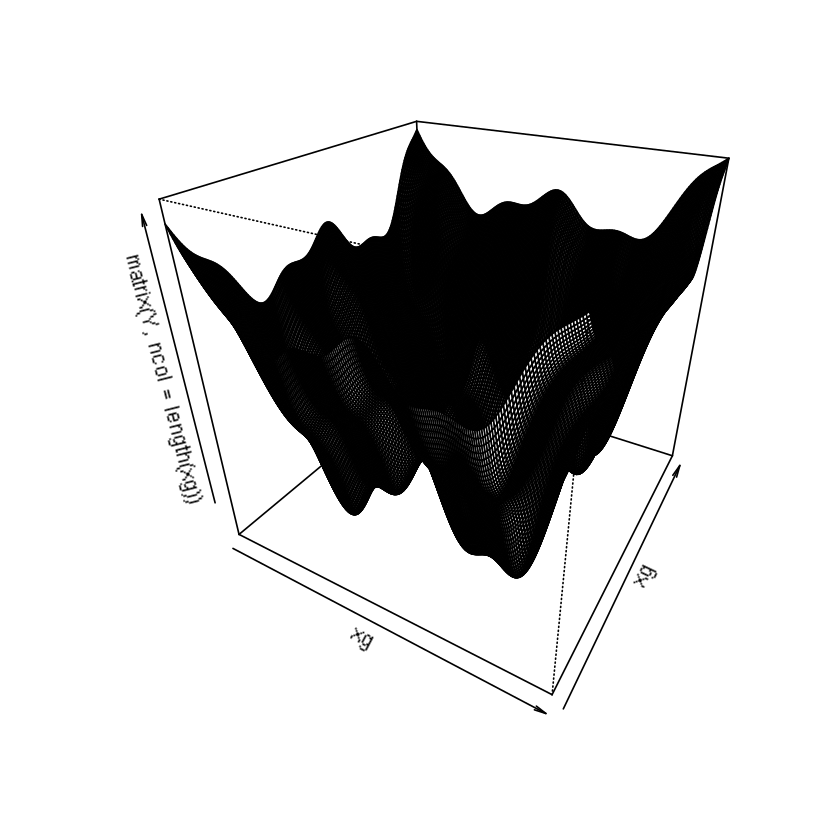

In [23]:
persp(xg, xg, matrix(Y, ncol=length(xg)), theta = 30, phi = 30)

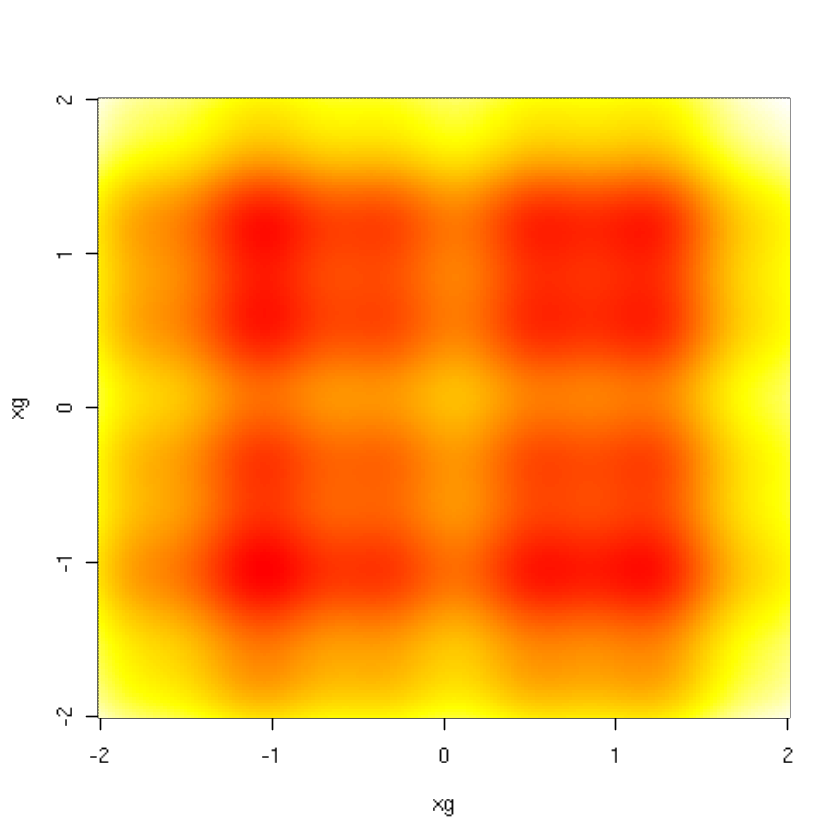

In [24]:
image(xg, xg, matrix(Y, ncol=length(xg)), col=heat.colors(128))

In [43]:
library(laGP)
Xref <- matrix(c(-1.725, 1.725), nrow=1)
# Xref <- matrix(c(0, 0), nrow=1)
p.mspe <- laGP(Xref, 6, 50, X, Y, d=0.1, method="mspe")
p.alc <- laGP(Xref, 6, 50, X, Y, d=0.1, method="alc")

In [44]:
range(X[p.mspe$Xi,2])

[1] 1.44 1.96

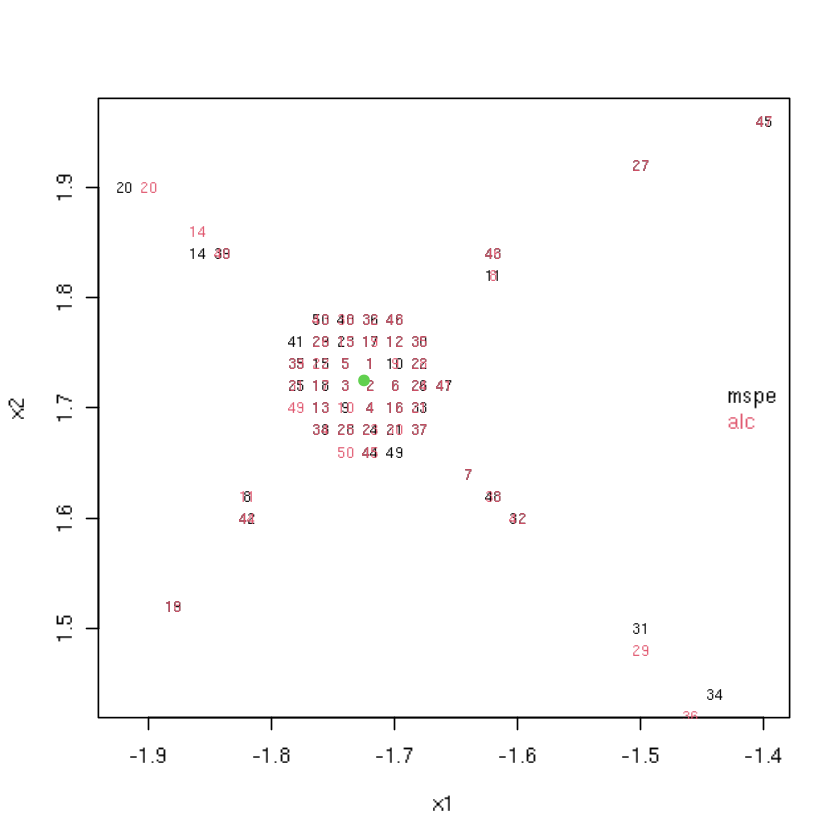

In [45]:
plot(X[p.mspe$Xi,], xlab="x1", ylab="x2", type="n", 
  xlim=range(X[p.mspe$Xi,1]), ylim=range(X[p.mspe$Xi,2]))
#    xlim=c(-2, 2), ylim=c(-2, 2))
text(X[p.mspe$Xi,], labels=1:length(p.mspe$Xi), cex=0.7)
text(X[p.alc$Xi,], labels=1:length(p.alc$Xi), cex=0.7, col=2)
points(Xref[1], Xref[2],pch =19, col=3)
legend("right", c("mspe", "alc"), text.col=c(1,2), bty="n")

In [46]:
p <- rbind(c(p.mspe$mean, p.mspe$s2, p.mspe$df), 
  c(p.alc$mean, p.alc$s2, p.alc$df))
colnames(p) <- c("mean", "s2", "df")
rownames(p) <- c("mspe", "alc")
p

,mean,s2,df
mspe,-0.3725312,2.518666e-06,50
alc,-0.3724825,2.283907e-06,50


In [47]:
mle <- rbind(p.mspe$mle, p.alc$mle)
rownames(mle) <- c("mspe", "alc")
mle

,d,dits
,<dbl>,<int>
mspe,0.3588531,7
alc,0.3565506,7


In [48]:
ts <- c(mspe=p.mspe$time, alc=p.alc$time)
ts 

mspe.elapsed  alc.elapsed 
       0.192        0.132

In [49]:
p.nn <- laGP(Xref, 6, 50, X, Y, d=0.1, method="nn")
p <- rbind(p, nn=c(p.nn$mean, p.nn$s2, p.nn$df))
mle <- rbind(mle, nn=p.nn$mle)
ts <- c(ts, nn=p.nn$time)
cbind(p, mle, ts)

,mean,s2,df,d,dits,ts
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
mspe,-0.3725312,2.518666e-06,50,0.3588531,7,0.192
alc,-0.3724825,2.283907e-06,50,0.3565506,7,0.132
nn,-0.3726306,8.675170e-07,50,0.2096316,6,0.003


### 9.3.3 Global LAGP surrogate

In [50]:
xx <- seq(-1.97, 1.95, by=0.04)
XX <- as.matrix(expand.grid(xx, xx))
YY <- herbtooth(XX)

In [51]:
nth <- 8
P.alc <- aGP(X, Y, XX, omp.threads=nth, verb=0)
P.alc$time

elapsed 
 77.776

In [52]:
nth <- 4
P.alc <- aGP(X, Y, XX, omp.threads=nth, verb=0)
P.alc$time

elapsed 
106.043

In [57]:
str(P.alc)

List of 10
 $ mean  : num [1:9801] -0.255 -0.275 -0.293 -0.309 -0.322 ...
 $ var   : num [1:9801] 2.01e-06 1.64e-06 1.44e-06 1.31e-06 1.69e-06 ...
 $ llik  : num [1:9801] 212 215 219 225 218 ...
 $ d     :List of 5
  ..$ mle  : logi TRUE
  ..$ start: num 0.612
  ..$ max  : num 30.4
  ..$ min  : num 2e-04
  ..$ ab   : num [1:2] 1.5 0.128
 $ g     :List of 5
  ..$ start: num 1e-04
  ..$ mle  : logi FALSE
  ..$ max  : num 1e-04
  ..$ min  : num 1.49e-08
  ..$ ab   : num [1:2] 0 0
 $ time  : Named num 106
  ..- attr(*, "names")= chr "elapsed"
 $ method: chr "alc"
 $ close : num 1050
 $ mle   :'data.frame':	9801 obs. of  2 variables:
  ..$ d   : num [1:9801] 0.327 0.294 0.256 0.246 0.253 ...
  ..$ dits: int [1:9801] 7 6 10 25 27 23 5 8 24 25 ...
 $ Xi    : num [1:9801, 1:50] 204 205 409 410 413 214 215 418 421 422 ...


In [53]:
p.alc$time*nrow(XX)/8

elapsed 
161.7165

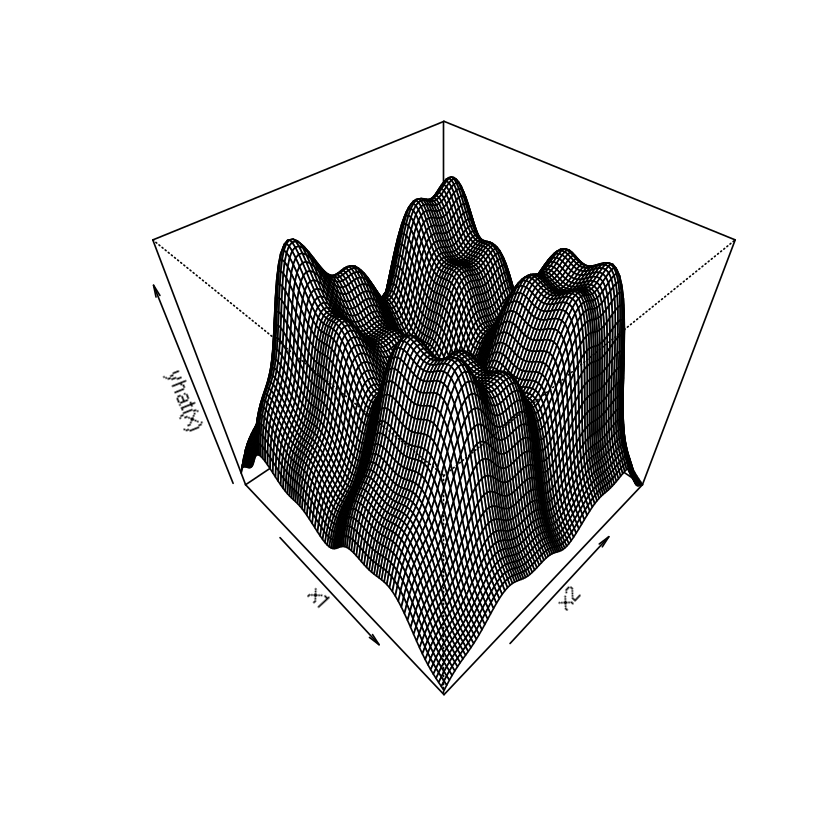

In [126]:
persp(xx, xx, -matrix(P.alc$mean, ncol=length(xx)), phi=45, theta=45, 
    xlab="x1", ylab="x2", zlab="yhat(x)")

In [58]:
med <- 0.51
zs <- XX[,2] == med
sv <- sqrt(P.alc$var[zs])
r <- range(c(-P.alc$mean[zs] + 2*sv, -P.alc$mean[zs] - 2*sv))

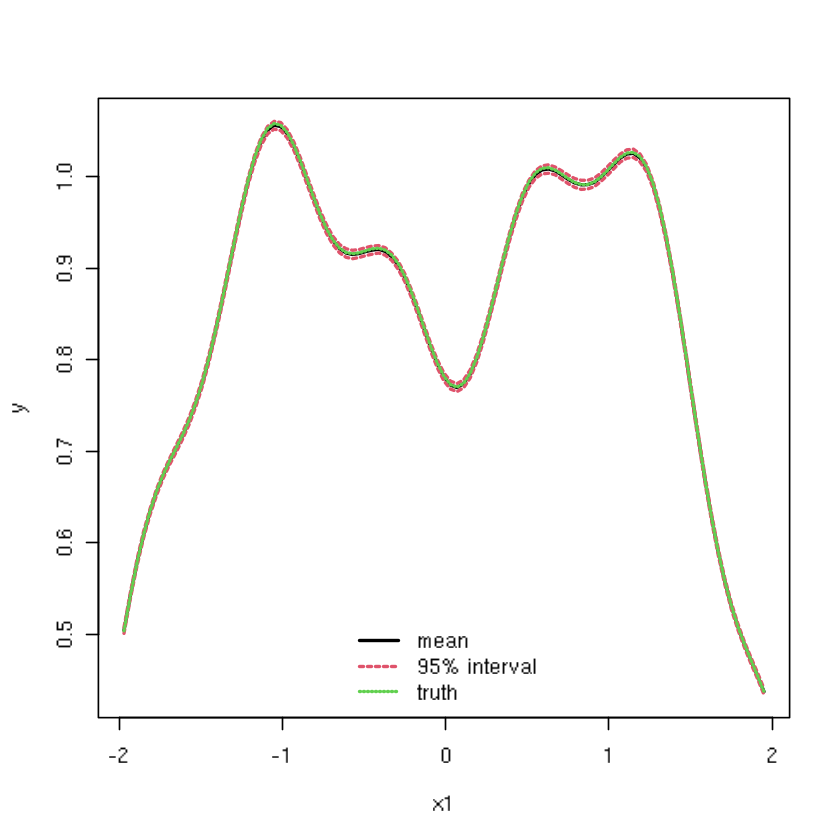

In [62]:
plot(XX[zs,1], -P.alc$mean[zs], type="l", lwd=2, ylim=r, 
  xlab="x1", ylab="y")
lines(XX[zs,1], -P.alc$mean[zs] + 2*sv, col=2, lty=2, lwd=2)
lines(XX[zs,1], -P.alc$mean[zs] - 2*sv, col=2, lty=2, lwd=2)
lines(XX[zs,1], -YY[zs], col=3, lwd=2, lty=3)
legend("bottom", c("mean", "95% interval", "truth"), lwd=2, lty=1:3, 
  col=1:3, bty="n")

In [63]:
diff <- P.alc$mean - YY

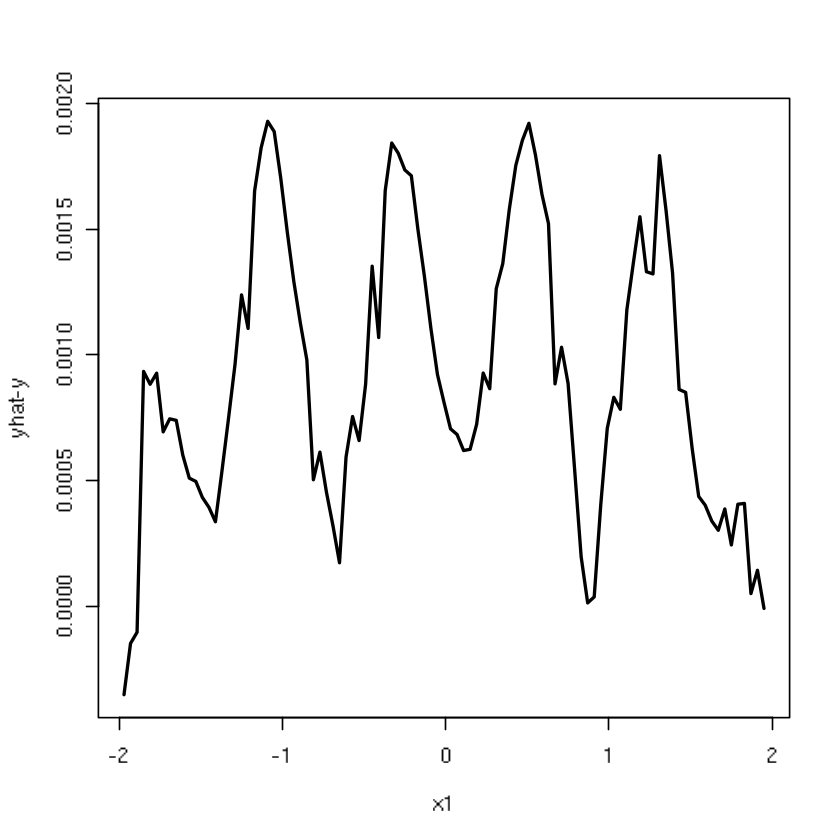

In [130]:
plot(XX[zs,1], diff[zs], type="l", lwd=2, xlab="x1", ylab="yhat-y")

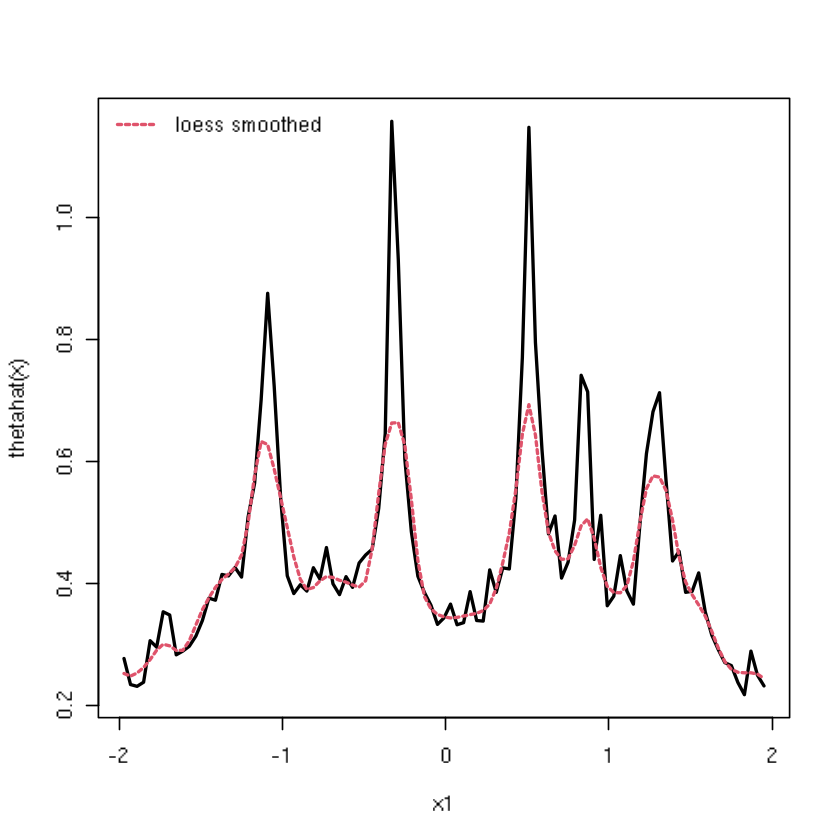

In [70]:
plot(XX[zs,1], P.alc$mle$d[zs], type="l", lwd=2, xlab="x1", 
  ylab="thetahat(x)")
df <- data.frame(y=log(P.alc$mle$d), XX)
lo <- loess(y ~ ., data=df, span=0.01)
lines(XX[zs,1], exp(lo$fitted)[zs], col=2, lty=2, lwd=2)
legend("topleft", "loess smoothed", col=2, lty=2, lwd=2, bty="n")

In [74]:
nth=8
P.alc2 <- aGP(X, Y, XX, d=exp(lo$fitted), omp.threads=nth, verb=0)

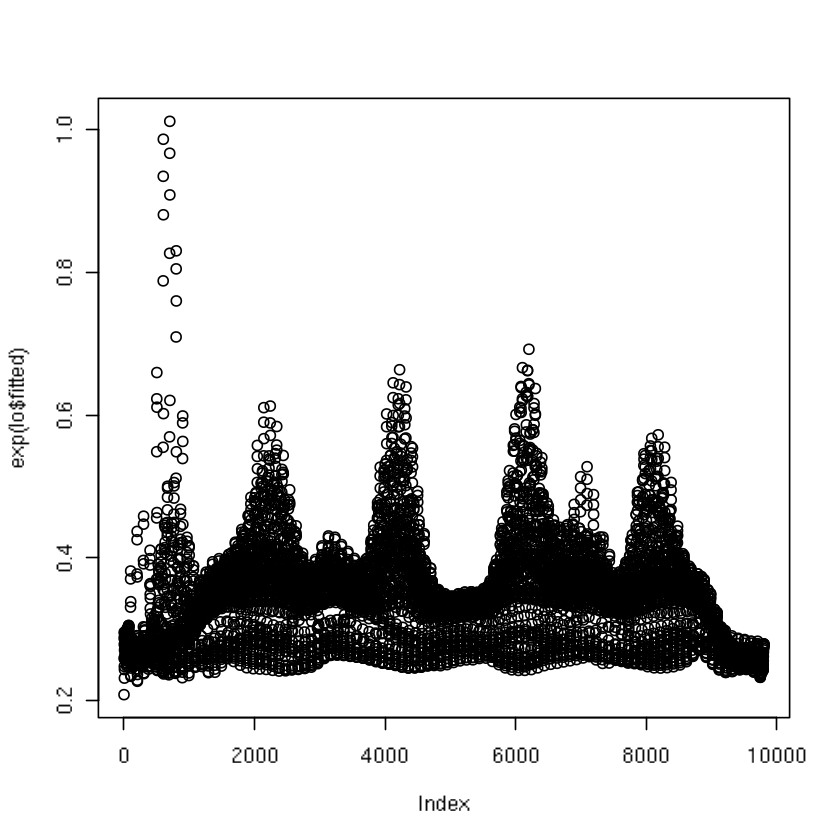

In [75]:
rmse <- data.frame(
  alc=sqrt(mean((P.alc$mean - YY)^2)), 
  alc2=sqrt(mean((P.alc2$mean - YY)^2)))
rmse

alc,alc2
<dbl>,<dbl>
0.0006275679,0.000299956


**borehole revisited**

In [87]:
borehole <- function(x)
 {
  rw <- x[1]*(0.15 - 0.05) + 0.05
  r <-  x[2]*(50000 - 100) + 100
  Tu <- x[3]*(115600 - 63070) + 63070
  Hu <- x[4]*(1110 - 990) + 990
  Tl <- x[5]*(116 - 63.1) + 63.1
  Hl <- x[6]*(820 - 700) + 700
  L <-  x[7]*(1680 - 1120) + 1120
  Kw <- x[8]*(12045 - 9855) + 9855
  m1 <- 2*pi*Tu*(Hu - Hl)
  m2 <- log(r/rw)
  m3 <- 1 + 2*L*Tu/(m2*rw^2*Kw) + Tu/Tl
  return(m1/m2/m3)
 }
scorep <- function(YY, mu, s2) { mean(-(mu - YY)^2/s2 - log(s2)) }

In [80]:
n <- 4000
nn <- 500
m <- 8
library(lhs)
x <- randomLHS(n + nn, m)
y <- apply(x, 1, borehole)
X <- x[1:n,]
Y <- y[1:n]
XX <- x[-(1:n),]
YY <- y[-(1:n)]

In [81]:
X <- x[1:n,]
Y <- y[1:n]
XX <- x[-(1:n),]
YY <- y[-(1:n)]

In [88]:
out1 <- aGP(X, Y, XX, d=list(max=20), omp.threads=nth, verb=0)
out2 <- aGP(X, Y, XX, d=list(start=out1$mle$d, max=20), 
  omp.threads=nth, verb=0)

In [91]:
times <- c(aGP=as.numeric(out1$time), aGP2=as.numeric(out2$time))
scores <- c(aGP=scorep(YY, out1$mean, out1$var), 
  aGP2=scorep(YY, out2$mean, out2$var))
rbind(times, scores)

,aGP,aGP2
times,4.1760000,4.2830000
scores,-0.5524711,-0.5174421


In [92]:
outs <- aGPsep(X, Y, XX, d=list(max=20), omp.threads=nth, verb=0)

In [93]:
times <- c(times, aGPs=as.numeric(outs$time))
scores <- c(scores, aGPs=scorep(YY, outs$mean, outs$var))
rbind(times, scores)

,aGP,aGP2,aGPs
times,4.1760000,4.2830000,4.3990000
scores,-0.5524711,-0.5174421,0.2374542


### 9.3.4 Global/local multi-resolution effect

In [97]:
tic <- proc.time()[3]
nsub <- 1000
d2 <- darg(list(mle=TRUE, max=100), X)
subs <- sample(1:nrow(X), nsub, replace=FALSE)
gpsi <- newGPsep(X[subs,], Y[subs], rep(d2$start, m), g=1/1000, dK=TRUE)
that <- mleGPsep(gpsi, tmin=d2$min, tmax=d2$max, ab=d2$ab, maxit=200)
psub <- predGPsep(gpsi, XX, lite=TRUE)
deleteGPsep(gpsi)
toc <- as.numeric(proc.time()[3] - tic)
that$d

[1]  0.433181 33.655502 30.137437  5.010002 33.278600  5.953840  2.460272
[8] 12.438517

In [98]:
times <- c(times, sub=toc)
scores <- c(scores, sub=scorep(YY, psub$mean, psub$s2))
rbind(times, scores)

,aGP,aGP2,aGPs,sub,sub
times,4.1760000,4.2830000,4.3990000,5.8890000,8.0980000
scores,-0.5524711,-0.5174421,0.2374542,0.8296211,0.8159919


In [100]:
scale <- sqrt(that$d)
Xs <- X
XXs <- XX
for(j in 1:ncol(Xs)) {
  Xs[,j] <- Xs[,j]/scale[j]
  XXs[,j] <- XXs[,j]/scale[j]
}

In [101]:
out3  <- aGP(Xs, Y, XXs, d=list(start=1, max=20), omp.threads=nth, verb=0)

In [102]:
out4  <- aGP(Xs, Y, XXs, d=list(start=1, max=20), g=1/10000000, 
  omp.threads=nth, verb=0)

In [103]:
times <- c(times, aGPsm=as.numeric(out3$time), 
  aGPsmg=as.numeric(out4$time))
scores <- c(scores, aGPsm=scorep(YY, out3$mean, out3$var), 
  aGPsmg=scorep(YY, out4$mean, out4$var))
t(rbind(times, scores))

,times,scores
aGP,4.176,-0.5524711
aGP2,4.283,-0.5174421
aGPs,4.399,0.2374542
sub,5.889,0.8296211
sub,8.098,0.8159919
aGPsm,4.332,1.1865037
aGPsmg,4.247,5.4688917


### 9.3.5 Details and variations

In [115]:
x <- seq(-2, 2, by=0.02)
X <- as.matrix(expand.grid(x, x))
Y <- herbtooth(X)
wx <- seq(-0.85, 0.45, length=100)
W <- cbind(wx - 0.75, wx^3 + 0.51)

In [116]:
p.alc <- laGPsep(W, 6, 100, X, Y, close=10000, lite=FALSE)
p.nn <- laGPsep(W, 6, 100, X, Y, method="nn", close=10000, lite=FALSE)
p.alcopt <- laGPsep(W, 6, 100, X, Y, method="alcopt", lite=FALSE)

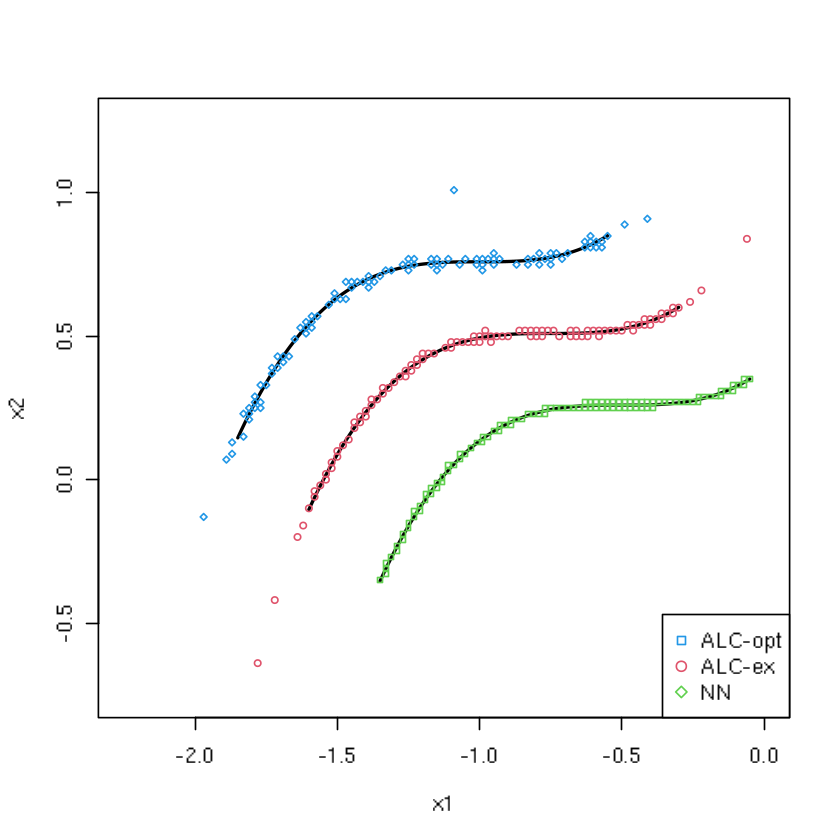

In [117]:
plot(W, type="l", xlab="x1", ylab="x2", xlim=c(-2.25,0), 
  ylim=c(-0.75,1.25), lwd=2)
points(X[p.alc$Xi,], col=2, cex=0.6)
lines(W[,1] + 0.25, W[,2] - 0.25, lwd=2)
points(X[p.nn$Xi,1] + 0.25, X[p.nn$Xi,2] - 0.25, pch=22, col=3, cex=0.6)
lines(W[,1] - 0.25, W[,2] + 0.25, lwd=2) 
points(X[p.alcopt$Xi,1] - 0.25, X[p.alcopt$Xi,2] + 0.25, pch=23, 
  col=4, cex=0.6)
legend("bottomright", c("ALC-opt", "ALC-ex", "NN"), 
  pch=c(22, 21, 23), col=c(4, 2, 3))

In [118]:
c(alc=p.alc$time, alcopt=p.alcopt$time, nn=p.nn$time)

alc.elapsed alcopt.elapsed     nn.elapsed 
        10.451          0.154          0.026

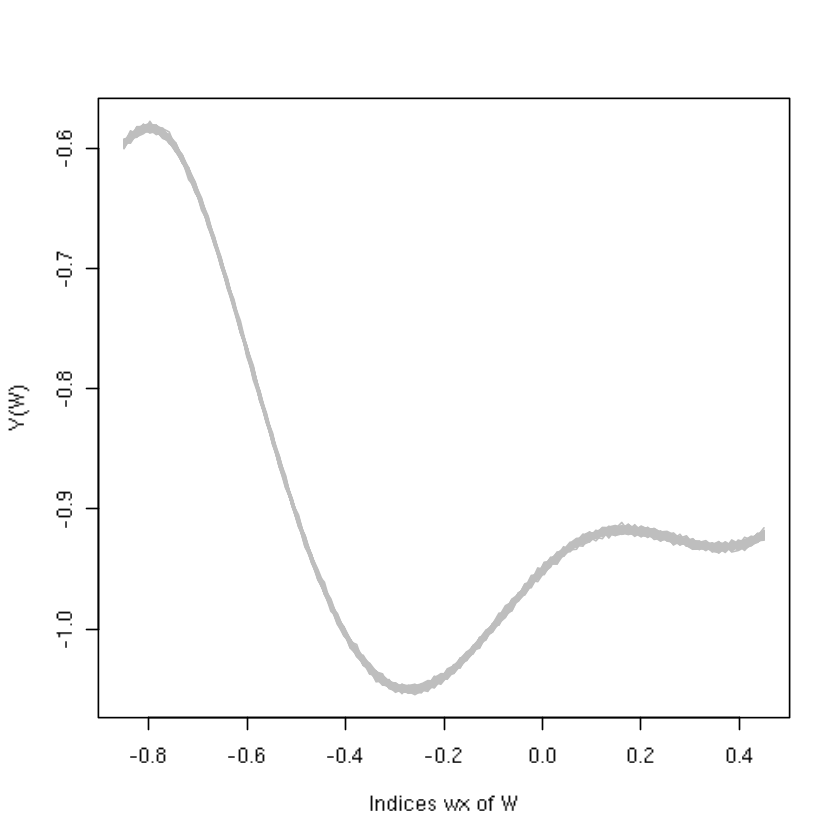

In [119]:
# install.packages("randLine")
library(mvtnorm)
YY <- rmvnorm(100, p.alc$mean, p.alc$Sigma)
matplot(wx, t(YY), col="gray", type="l", lty=1, 
  xlab="Indices wx of W", ylab="Y(W)")

### 9.3.6 Two applications

#### Satellite drag

In [1]:
setwd("/root")
dir()
library(laGP)

[1] "README.md"                   "ch01.Rmd"                   
 [3] "ch01.nb.html"                "ch02.Rmd"                   
 [5] "ch02.nb.html"                "ch03.Rmd"                   
 [7] "ch03.nb.html"                "ch04.Rmd"                   
 [9] "ch04.nb.html"                "ch05.ipynb"                 
[11] "ch06.ipynb"                  "ch07.ipynb"                 
[13] "ch08.ipynb"                  "ch09.ipynb"                 
[15] "ch10.ipynb"                  "data"                       
[17] "data-ignored"                "input"                      
[19] "lagp-benchmark.ipynb"        "study-surrogates-2020.Rproj"
[21] "test-laGP-RPV.ipynb"         "test-linear.Rmd"            
[23] "test-linear.nb.html"

In [2]:
hstHe <- read.table("./data-ignored/lanl/HST/hstHe.dat", header=TRUE)
nrow(hstHe)

[1] 1000000

In [3]:
head(hstHe)

,Umag,Ts,Ta,alphan,sigmat,theta,phi,panang,Cd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,6135.036,397.9691,906.2802,0.5306565,0.49013760,-0.02590028,-1.5152090,0,3.615377
2,9328.086,327.1921,712.4511,0.1449230,0.78814610,-2.11896400,-1.1794540,0,2.347620
3,5886.927,201.1139,1528.6840,0.1234521,0.10902040,-2.53437100,-0.2074805,0,2.905388
4,7379.823,455.1714,306.7498,0.9181930,0.64186560,-1.53530400,-0.8911418,0,1.823454
5,6706.873,449.1331,1640.1990,0.2173120,0.07075154,2.07184400,-1.3360050,0,1.639812
6,8080.669,171.5746,807.8876,0.4437979,0.08796270,-1.20662100,0.8946316,0,1.466504


In [4]:
m <- ncol(hstHe) - 1
X <- hstHe[,1:m]
Y <- hstHe[,m+1]
maxX <- apply(X, 2, max)
minX <- apply(X, 2, min)
for(j in 1:ncol(X)) {
  X[,j] <- X[,j] - minX[j]
  X[,j] <- X[,j]/(maxX[j] - minX[j])
}
range(Y)

[1] 0.3960984 9.1919790

In [5]:
cv.folds <- function (n, folds=10)
  split(sample(1:n), rep(1:folds, length=n))
f <- cv.folds(nrow(X))

In [6]:
str(f)

List of 10
 $ 1 : int [1:100000] 467993 896833 505900 65096 944052 491153 345214 611096 90444 467847 ...
 $ 2 : int [1:100000] 942448 540501 116368 715147 281073 199499 338619 505797 841404 214250 ...
 $ 3 : int [1:100000] 765095 562421 48924 52134 372163 594956 922125 538890 946245 785355 ...
 $ 4 : int [1:100000] 726716 601766 253963 1052 864544 405831 434790 860933 826653 363671 ...
 $ 5 : int [1:100000] 669456 362312 42696 948477 680289 714094 486888 354884 715173 592019 ...
 $ 6 : int [1:100000] 719004 700445 217258 382744 550423 541758 50170 704065 361419 282994 ...
 $ 7 : int [1:100000] 486032 674437 644633 580039 951076 794436 767104 754117 957794 564356 ...
 $ 8 : int [1:100000] 105336 937398 907660 100058 532172 9952 29785 998493 854991 442680 ...
 $ 9 : int [1:100000] 125930 948801 534507 808281 820008 140055 244176 802016 524741 492549 ...
 $ 10: int [1:100000] 194214 146050 795907 232552 304784 922349 129014 120630 461287 582675 ...


In [7]:
i <- 1
o <- f[[i]]
Xtest <- X[o,]
Xtrain <- X[-o,]
Ytest <- Y[o]
Ytrain <- Y[-o]
c(test=length(Ytest), train=length(Ytrain))

test  train 
100000 900000

In [8]:
da.orig <- darg(list(mle=TRUE), Xtrain, samp.size=10000)
sub <- sample(1:nrow(Xtrain), 1000, replace=FALSE)
gpsi <- newGPsep(Xtrain[sub,], Ytrain[sub], d=0.1, g=1/1000, dK=TRUE)
mle <- mleGPsep(gpsi, tmin=da.orig$min, tmax=10*da.orig$max, ab=da.orig$ab)
psub <- predGPsep(gpsi, Xtest, lite=TRUE)
deleteGPsep(gpsi)
rmspe <- c(sub=sqrt(mean((100*(psub$mean - Ytest)/Ytest)^2)))
rmspe

sub 
9.691125

In [9]:
nth <- 8 # cores
alcsep <- aGPsep(Xtrain, Ytrain, Xtest, d=da.orig, omp.threads=nth, verb=0)
rmspe <- c(rmspe, alc=sqrt(mean((100*(alcsep$mean - Ytest)/Ytest)^2)))
rmspe

sub      alc 
9.691125 5.825143

In [10]:
for(j in 1:ncol(Xtrain)) {
  Xtrain[,j] <- Xtrain[,j]/sqrt(mle$d[j])
  Xtest[,j] <- Xtest[,j]/sqrt(mle$d[j])
}

In [11]:
da.s <- darg(list(mle=TRUE), Xtrain, samp.size=10000)
da.s$start <- 1

In [12]:
alcsep.s <- aGPsep(Xtrain, Ytrain, Xtest, d=da.s, omp.threads=nth, verb=0)
rmspe <- c(rmspe, alcs=sqrt(mean((100*(alcsep.s$mean - Ytest)/Ytest)^2)))
rmspe

sub       alc      alcs 
9.6911248 5.8251428 0.7885207

In [13]:
round(c(alc=alcsep$time/60, alcs=alcsep.s$time/60))

alc.elapsed alcs.elapsed 
          20           17

In [14]:
itrat <- alcsep$mle$dits/alcsep.s$mle$dits 
c(better=mean(itrat > 1), x2=mean(itrat > 2))

better      x2 
0.78539 0.22127

### Large-scale calibration

In [16]:
M <- function(x, u) 
 {
  x <- as.matrix(x)
  u <- as.matrix(u)
  out <- (1 - exp(-1/(2*x[,2]))) 
  out <- out*(1000*u[,1]*x[,1]^3 + 1900*x[,1]^2 + 2092*x[,1] + 60) 
  out <- out/(100*u[,2]*x[,1]^3 + 500*x[,1]^2 + 4*x[,1] + 20)  
  return(out)
 }

In [17]:
bias <- function(x) 
 {
  x <- as.matrix(x)   
  out <- (10*x[,1]^2 + 4*x[,2]^2)/(50*x[,1]*x[,2] + 10)
  return(out)
 }

In [21]:
library(lhs)
ny <- 50
X <- randomLHS(ny, 2)
u <- c(0.2, 0.1)
Zu <- M(X, matrix(u, nrow=1))
sd <- 0.5
reps <- 2
Y <- rep(Zu, reps) + rep(bias(X), reps) + rnorm(reps*length(Zu), sd=sd)
length(Y)

[1] 100

In [22]:
nz <- 10000
XU <- randomLHS(nz, 4)
XU2 <- matrix(NA, nrow=10*ny, ncol=4)
for(i in 1:10) {
  I <- ((i-1)*ny + 1):(ny*i)
  XU2[I, 1:2] <- X
}
XU2[,3:4] <- randomLHS(10*ny, 2)
XU <- rbind(XU, XU2)
Z <- M(XU[,1:2], XU[,3:4])
length(Z)

[1] 10500

In [23]:
bias.est <- TRUE
methods <- rep("alc", 2)
da <- d <- darg(NULL, XU)
g <- garg(list(mle=TRUE), Y)

In [33]:
lprior <- function(u, shape1=2, shape2=2) 
  sum(dbeta(u, shape1, shape2, log=TRUE))

In [34]:
initsize <- 10*ncol(X)
uinit <- maximinLHS(initsize, 2)
uinit <- 0.9*uinit + 0.05

In [35]:
llinit <- rep(NA, nrow(uinit))
for(i in 1:nrow(uinit)) {
  llinit[i] <- fcalib(uinit[i,], XU, Z, X, Y, da, d, g, lprior, 
    methods, NULL, bias.est, nth, verb=0)
}

In [39]:
install.packages("crs")   # error 유발
library(crs)
imesh <- 0.1
opts <- list("MAX_BB_EVAL"=1000, "INITIAL_MESH_SIZE"=imesh, 
  "MIN_POLL_SIZE"="r0.001", "DISPLAY_DEGREE"=0)

Warning message in install.packages("crs"):
“installation of package ‘crs’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in library(crs): there is no package called ‘crs’


In [40]:
its <- 0
i <- 1
out <- NULL
o <- order(llinit)
while(its < 10) {
  outi <- snomadr(fcalib, 2, c(0,0), 0, x0=uinit[o[i],], lb=c(0,0), 
    ub=c(1,1), opts=opts, XU=XU, Z=Z, X=X, Y=Y, da=da, d=d, g=g, 
    methods=methods, M=NULL, verb=0, bias=bias.est, omp.threads=nth, 
    uprior=lprior, save.global=.GlobalEnv)
    its <- its + outi$iterations
    if(is.null(out) || outi$objective < out$objective) out <- outi
    i <- i + 1
}

ERROR: Error in snomadr(fcalib, 2, c(0, 0), 0, x0 = uinit[o[i], ], lb = c(0, : could not find function "snomadr"


In [41]:
Xp <- rbind(uinit, as.matrix(fcalib.save[,1:2]))
Zp <- c(-llinit, fcalib.save[,3])
wi <- which(!is.finite(Zp))
if(length(wi) > 0) { 
  Xp <- Xp[-wi, ]
  Zp <- Zp[-wi]
}
library(akima)
surf <- interp(Xp[,1], Xp[,2], Zp, duplicate="mean")
u.hat <- out$solution

ERROR: Error in as.matrix(fcalib.save[, 1:2]): object 'fcalib.save' not found


In [42]:
image(surf, xlab="u1", ylab="u2", col=heat.colors(128), 
  xlim=c(0,1), ylim=c(0,1))
points(uinit)
points(fcalib.save[,1:2], col=3, pch=18)
points(u.hat[1], u.hat[2], col=4, pch=18)
abline(v=u[1], lty = 2)
abline(h=u[2], lty = 2)

ERROR: Error in image(surf, xlab = "u1", ylab = "u2", col = heat.colors(128), : object 'surf' not found


In [43]:
obju <- fcalib(u, XU, Z, X, Y, da, d, g, lprior, methods, NULL, bias.est, 
  nth, verb=0)
c(u.hat=out$objective, u.star=obju)

u.star 
133.93

In [44]:
Xu <- cbind(X, matrix(rep(u, ny), ncol=2, byrow=TRUE))
Mhat.u <- aGP.seq(XU, Z, Xu, da, methods, ncalib=2, 
  omp.threads=nth, verb=0)
cmle.u <- discrep.est(X, Y, Mhat.u$mean, d, g, bias.est, FALSE)
cmle.u$ll <- cmle.u$ll + lprior(u)
-cmle.u$ll

[1] 133.93

In [45]:
nny <- 1000
XX <- randomLHS(nny, 2)
ZZu <- M(XX, matrix(u, nrow=1))
YYtrue <- ZZu + bias(XX)

In [46]:
XXu <- cbind(XX, matrix(rep(u, nny), ncol=2, byrow=TRUE))
Mhat.oos.u <- aGP.seq(XU, Z, XXu, da, methods, ncalib=2, 
  omp.threads=nth, verb=0)
YYm.pred.u <- predGP(cmle.u$gp, XX)
YY.pred.u <- YYm.pred.u$mean + Mhat.oos.u$mean
rmse.u <- sqrt(mean((YY.pred.u - YYtrue)^2))
deleteGP(cmle.u$gp)

In [47]:
Xu <- cbind(X, matrix(rep(u.hat, ny), ncol=2, byrow=TRUE))
Mhat <- aGP.seq(XU, Z, Xu, da, methods, ncalib=2, omp.threads=nth, verb=0)
cmle <- discrep.est(X, Y, Mhat$mean, d, g, bias.est, FALSE)
cmle$ll <- cmle$ll + lprior(u.hat)

ERROR: Error in matrix(rep(u.hat, ny), ncol = 2, byrow = TRUE): object 'u.hat' not found


In [ ]:
c(-cmle$ll, out$objective)

In [48]:
XXu <- cbind(XX, matrix(rep(u.hat, nny), ncol=2, byrow=TRUE))
Mhat.oos <- aGP.seq(XU, Z, XXu, da, methods, ncalib=2, 
  omp.threads=nth, verb=0)
YYm.pred <- predGP(cmle$gp, XX)
YY.pred <- YYm.pred$mean + Mhat.oos$mean
rmse <- sqrt(mean((YY.pred - YYtrue)^2))
deleteGP(cmle$gp)

ERROR: Error in matrix(rep(u.hat, nny), ncol = 2, byrow = TRUE): object 'u.hat' not found


In [49]:
c(u.hat=rmse, u=rmse.u)

ERROR: Error in eval(expr, envir, enclos): object 'rmse' not found
